In [32]:
from data.my_transforms import SquareDataTransform, NoTransform, transforms
from common.utils import to_cplx, tensor_to_complex_np
import numpy as np
import torch

In [33]:
from matplotlib import pyplot as plt

In [34]:
from models.dautomap.train_dautomap import create_data_loaders, build_model, SliceData

In [35]:
from pathlib import Path
from collections import namedtuple

In [36]:
args = {'center_fractions':[0.08],'accelerations':[2],'challenge':'singlecoil',
       'data_path':Path('/media/student1/NewVolume/MR_Reconstruction/datasets/fastmri/'),
       'resolution':320,
       'sample_rate':0.1,
       'batch_size':3,
        'device':'cuda',
        'data_parallel':False,
        'num_chans':32,
        'num_pools':4,
        'drop_prob':0
       }
# d_named = namedtuple("Employee", d.keys())(*d.values())

argsobj = namedtuple('args',args.keys())(*args.values())

# testing of dataset 

In [37]:
ds = SliceData(root=argsobj.data_path / f'{argsobj.challenge}_train',
              transform = NoTransform(),
              sample_rate = argsobj.sample_rate,
              challenge = argsobj.challenge)

In [38]:
ksp_1 = ds[299]

In [39]:
ksp_1.dtype

dtype('complex64')

In [40]:
kspace_rect = transforms.to_tensor(ksp_1)
image_rect = transforms.ifft2(kspace_rect)    ##rectangular FS image
image_square = transforms.complex_center_crop(image_rect, (argsobj.resolution, argsobj.resolution))  ##cropped to FS square image

In [41]:
from data.my_transforms import C3Convert, ifft_c3, fft_c3

c3obj = C3Convert((argsobj.resolution,argsobj.resolution))

In [42]:
kspace_square = c3obj.apply(transforms.fft2(image_square))  ##kspace of square iamge

In [43]:
ksp_npy = tensor_to_complex_np(kspace_square)

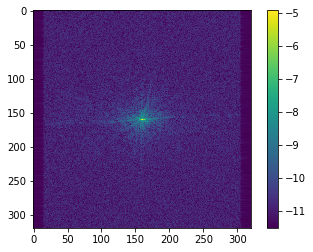

In [44]:
plt.imshow(np.log(1e-5+np.abs(ksp_npy)))
plt.colorbar()

In [45]:
rec = ifft_c3(kspace_square)
rec_abs = transforms.complex_abs(rec)
img, mean, std = transforms.normalize_instance(rec_abs, eps=1e-11)

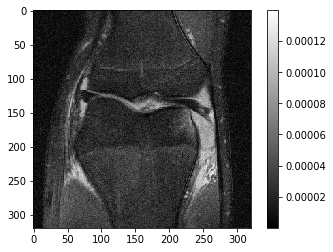

In [46]:
rec_npy = tensor_to_complex_np(rec)
plt.imshow(np.abs(rec_npy),cmap='gray')
plt.colorbar()

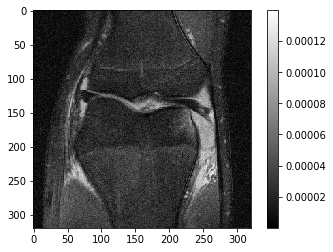

In [47]:
plt.imshow(rec_abs,cmap='gray')
plt.colorbar()

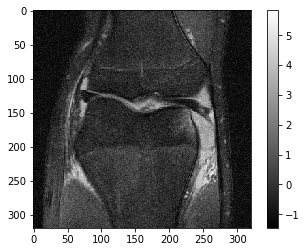

In [48]:
plt.imshow(img,cmap='gray')
plt.colorbar()

# Testing of data loader

In [49]:
train_loader, dev_loader, display_loader = create_data_loaders(argsobj)

In [50]:
for ksp,inp, tgt,_,_,_ in train_loader:
    print(ksp.shape,ksp.dtype)
    break

torch.Size([3, 2, 320, 320]) torch.float32


In [51]:
inp_npy = to_cplx(inp,0)
tgt_npy = to_cplx(tgt,0)

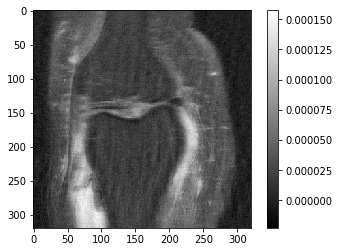

In [52]:
plt.imshow(np.real(inp_npy),cmap='gray')
plt.colorbar()

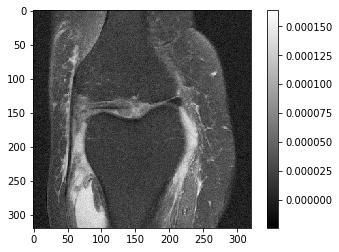

In [53]:
plt.imshow(np.real(tgt_npy),cmap='gray')
plt.colorbar()

In [59]:
from common.evaluate import psnr

In [60]:
psnr(np.abs(tgt_npy),np.abs(inp_npy))

26.05771102762262

# testing model forward

In [61]:
model = build_model(argsobj)

In [62]:
model

ModelWithDC(
  (module_): ResidualForm(
    (module_): dAUTOMAP(
      (domain_transform): GeneralisedIFT2Layer(
        (idft1): Conv2d(2, 640, kernel_size=(320, 1), stride=(1, 1), bias=False)
        (idft2): Conv2d(2, 640, kernel_size=(320, 1), stride=(1, 1), bias=False)
      )
      (domain_transform2): GeneralisedIFT2Layer(
        (idft1): Conv2d(2, 640, kernel_size=(320, 1), stride=(1, 1))
        (idft2): Conv2d(2, 640, kernel_size=(320, 1), stride=(1, 1))
      )
      (refinement_block): Sequential(
        (0): Conv2d(2, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (3): ReLU(inplace)
        (4): ConvTranspose2d(64, 2, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      )
    )
  )
  (dcs): DataConsistencyInKspace()
)

In [63]:
idft1 = model.module_.module_.domain_transform

In [64]:
type(idft1)

models.dautomap.dautomap_model.GeneralisedIFT2Layer

In [65]:
ksp_shifted = transforms.ifftshift(ksp,dim=(-2,-1))

In [66]:
output = idft1(ksp_shifted.cuda())

In [67]:
output.shape

torch.Size([3, 2, 320, 320])

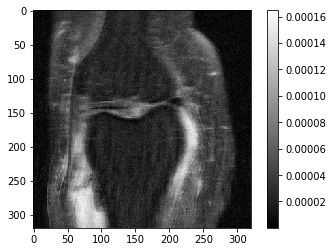

In [69]:
plt.imshow(np.abs(to_cplx(output,0)),cmap='gray')
plt.colorbar()